In [63]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import gmean, rankdata
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import KFold, cross_val_score

In [15]:
import missingno as msno

In [11]:
#!pip install catboost

In [14]:
#!pip install missingno

In [3]:
import catboost as cb

In [4]:
import warnings
warnings.simplefilter("ignore")

In [6]:
df_clp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/Competition/client_profile.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/Competition/test.csv')
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/Competition/train.csv')

print("df_clp.shape = {} rows, {} cols".format(*df_clp.shape))
print("df_test.shape = {} rows, {} cols".format(*df_test.shape))
print("df_train.shape = {} rows, {} cols".format(*df_train.shape))

df_clp.shape = 250000 rows, 24 cols
df_test.shape = 165141 rows, 2 cols
df_train.shape = 110093 rows, 3 cols


In [7]:
# объединяем трейн и тест
data = pd.concat([df_train, df_test], axis=0)
data = data.reset_index(drop=True)
data.head(n=2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0.0,Cash
1,123597908,1.0,Cash


In [8]:
def clean_input(data) -> pd.DataFrame:
    """
    Перевод названий колонок в нижний регистр и вывод основной информации о наборе данных

    Parameters
    ----------
    data: Pandas DataFrame

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    #base_path = "data"
    #data = pd.read_csv(f"{base_path}/{data_path}")
    # Приводим все названия колонок к нижнему регистру
    data.columns = [col.lower() for col in data.columns]
    #print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")
    print(f"shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data

In [9]:
df_clp = clean_input(df_clp)
data = clean_input(data)

shape = 250000 rows, 24 cols
shape = 275234 rows, 3 cols


In [10]:
data = data.merge(
    df_clp, how="left", on="application_number"
)

In [12]:
data.describe()

,application_number,target,childrens,total_salary,amount_credit,amount_annuity,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
count,2.752340e+05,110093.000000,223715.000000,2.237150e+05,2.237150e+05,223704.000000,223715.000000,223715.000000,223715.000000,76034.000000,223715.000000,223715.000000,223713.000000,97726.000000,223236.000000,179308.000000,193517.000000,193517.000000,193517.000000,193517.000000,193517.000000,193517.000000
mean,1.235771e+08,0.080813,0.417978,1.689732e+05,5.991977e+05,27125.336237,0.020864,16031.731288,67439.314986,12.033603,0.280308,0.056728,2.154801,0.502059,0.513979,0.510665,0.006268,0.006671,0.033992,0.267093,0.266710,1.896154
std,8.877727e+04,0.272550,0.722796,2.697500e+05,4.018597e+05,14528.794526,0.013800,4360.679026,139208.370439,11.872949,0.449150,0.231323,0.911605,0.210658,0.191094,0.195224,0.083505,0.103734,0.203277,0.911643,0.853882,1.867322
min,1.234233e+08,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000290,7489.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.014691,0.000001,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.235003e+08,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,0.010006,12412.000000,929.000000,5.000000,0.000000,0.000000,2.000000,0.333954,0.391806,0.368969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.235771e+08,0.000000,0.000000,1.485000e+05,5.175000e+05,24930.000000,0.018850,15745.000000,2213.000000,9.000000,0.000000,0.000000,2.000000,0.506102,0.565424,0.535276,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.236540e+08,0.000000,1.000000,2.025000e+05,8.086500e+05,34600.500000,0.028663,19678.000000,5657.500000,15.000000,1.000000,0.000000,3.000000,0.674368,0.663373,0.669057,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.237309e+08,1.000000,19.000000,1.170000e+08,4.050000e+06,230161.500000,0.072508,25229.000000,365243.000000,69.000000,1.000000,1.000000,20.000000,0.962693,0.855000,0.896010,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [16]:
#Анализ пропусков

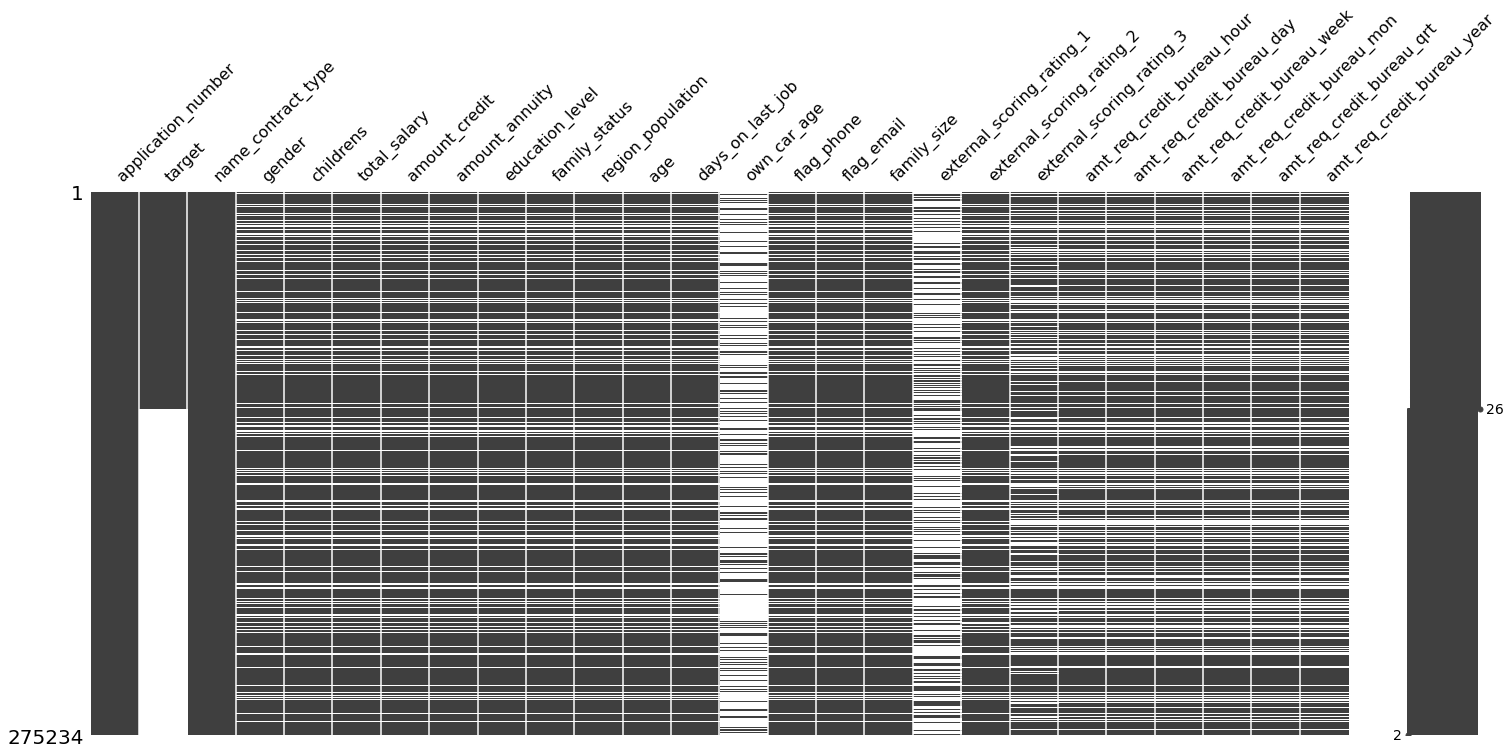

In [17]:
msno.matrix(data)

In [20]:
target = df_train['TARGET']

In [21]:
df_train.TARGET.value_counts()

0    101196
1      8897
Name: TARGET, dtype: int64

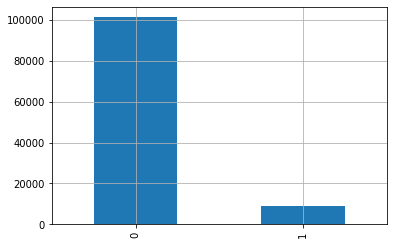

In [22]:
df_train.TARGET.value_counts().plot(kind='bar', grid = True)

In [23]:
# Переменная несбалансирована. Нужно проводить бининг, стратификацию и попробовать woe.

In [30]:
data.shape

(275234, 26)

In [28]:
# выделяем по маске данные из трейна и из теста
mask = data["target"].isnull()
features_to_drop = ["application_number", "target"]

# разделяем на трейн и тест
train, test = data.loc[~mask], data.loc[mask]

target, test_id = train["target"], test["application_number"]
train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

## Анализ признаков

In [24]:
numerical_features = data.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 22


Index(['application_number', 'target', 'childrens', 'total_salary',
       'amount_credit', 'amount_annuity', 'region_population', 'age',
       'days_on_last_job', 'own_car_age', 'flag_phone', 'flag_email',
       'family_size', 'external_scoring_rating_1', 'external_scoring_rating_2',
       'external_scoring_rating_3', 'amt_req_credit_bureau_hour',
       'amt_req_credit_bureau_day', 'amt_req_credit_bureau_week',
       'amt_req_credit_bureau_mon', 'amt_req_credit_bureau_qrt',
       'amt_req_credit_bureau_year'],
      dtype='object')

In [33]:
numerical_features = numerical_features.drop(['application_number', 'target'], axis=1)

## Дискретные признаки

In [26]:
discrete_feature = [
    feature for feature in numerical_features
    if len(data[feature].unique())<25
]

In [27]:
discrete_feature

['target',
 'childrens',
 'flag_phone',
 'flag_email',
 'family_size',
 'amt_req_credit_bureau_hour',
 'amt_req_credit_bureau_day',
 'amt_req_credit_bureau_week',
 'amt_req_credit_bureau_qrt']

In [29]:
#обратить внимание на флаги.

In [39]:
def group_graf(group):
    fig, axes = plt.subplots(5, 5, figsize=(17, 12))

    for num, feature in enumerate(group):
        try:
            train_data, test_data = train[feature].copy(), test[feature].copy()
            sns.kdeplot(train_data, ax=axes[num//5, num%5], color="blue", label="train")
            sns.kdeplot(test_data, ax=axes[num//5, num%5], color="green", label="test")
        except RuntimeError:
            pass
        except KeyError:
            train_data = train[feature].copy()
            sns.kdeplot(train_data, ax=axes[num//5, num%5], color="blue", label="train")
        axes[num//5, num%5].set_title(feature, fontsize=14)

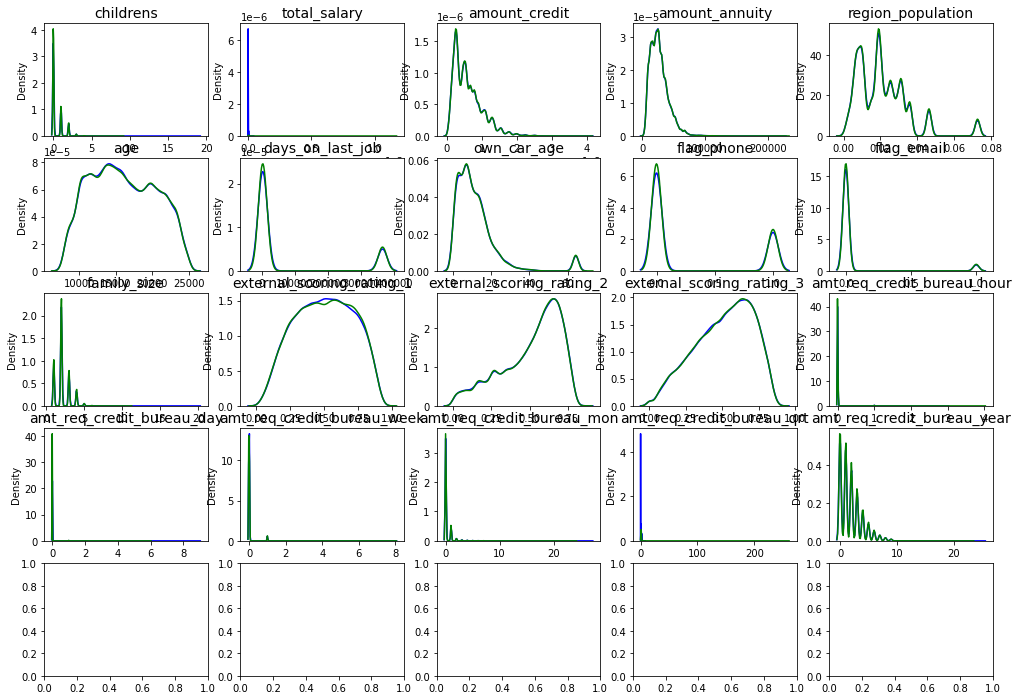

In [40]:
group = numerical_features
group_graf(group)

In [41]:
#немного напрягает total salary и amt_credit_bureau_year
#виден выброс по 'days on last job"

In [47]:
def feat_target_graf(group): 
    fig, axes = plt.subplots(5, 4, figsize=(17, 12))

    for num, feature in enumerate(group):
        target_0 = train.loc[df_train['TARGET'] == 0, feature]
        target_1 = train.loc[df_train['TARGET'] == 1, feature] 
                    
        sns.kdeplot(target_0, ax=axes[num//4, num%4], color="blue", label="0")
        sns.kdeplot(target_1, ax=axes[num//4, num%4], color="red", label="1")
            
        axes[num//4, num%4].set_title(feature, fontsize=14)

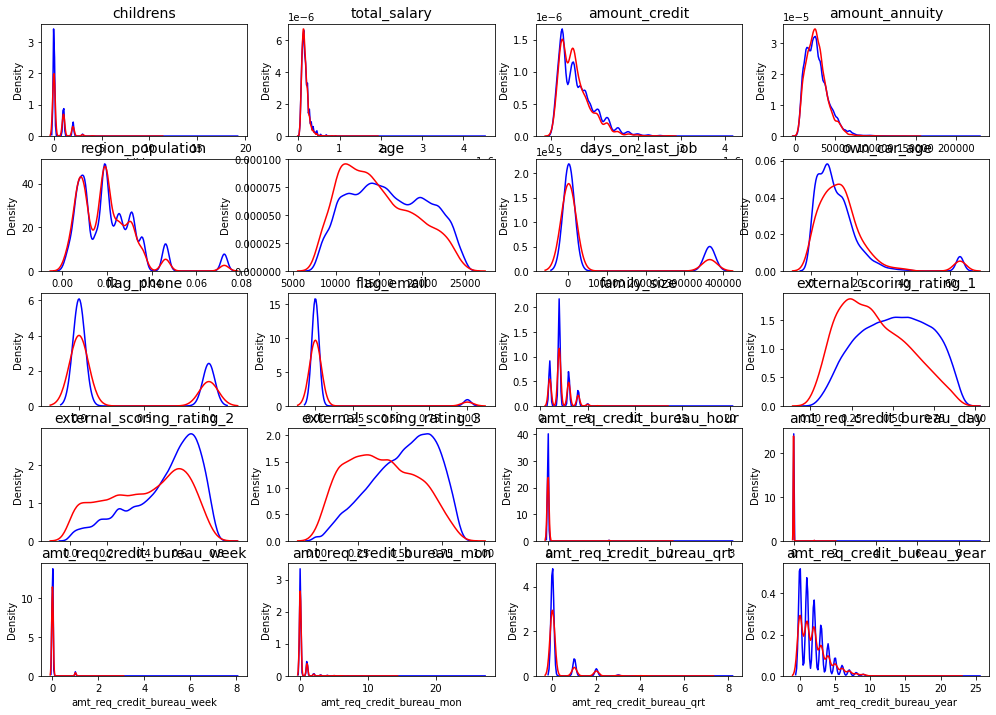

In [48]:
group = numerical_features
feat_target_graf(group)

In [50]:
from sklearn.ensemble import RandomForestRegressor

In [51]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestRegressor(**parameters)

CPU times: user 277 µs, sys: 45 µs, total: 322 µs
Wall time: 307 µs


In [55]:
numeric_features = numerical_features.columns.to_list()

In [57]:
#сразу оценим нелинейную связь

In [56]:
forest.fit(train[numeric_features].fillna(-9999), df_train['TARGET'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=2, oob_score=False,
                      random_state=27, verbose=0, warm_start=False)

Text(0.5, 1.0, 'What are the top important features to start with?')

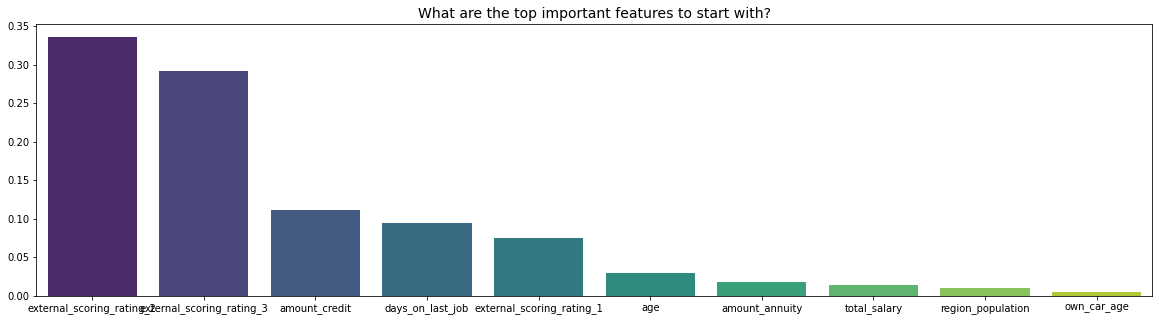

In [59]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = numerical_features.columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

In [61]:
X_adv = pd.concat([
    train[numeric_features], test[numeric_features]
])
y_adv = np.hstack(
    (np.ones(train.shape[0]), np.zeros(test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [64]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)
print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.4995
CPU times: user 1min 7s, sys: 86.3 ms, total: 1min 7s
Wall time: 35.1 s


Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

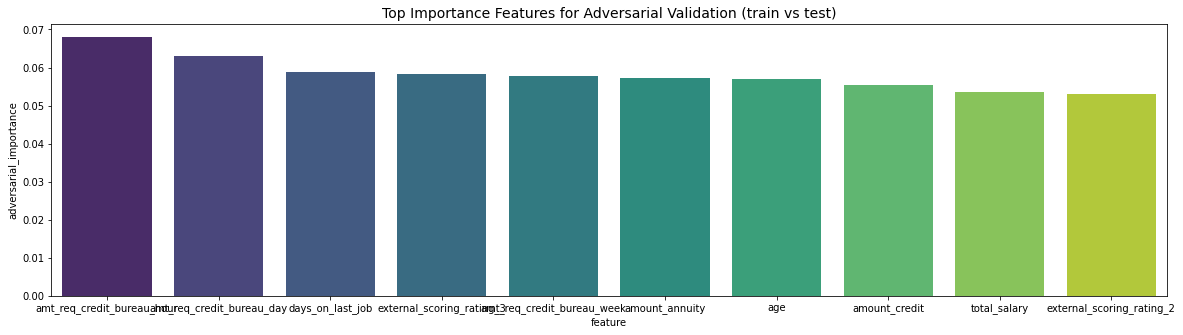

In [65]:
model.fit(X_adv, y_adv)

importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)